In [ ]:
### dependencies

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
import nltk
from sklearn import linear_model
from sklearn.feature_extraction.text import TfidfVectorizer , CountVectorizer
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.metrics import accuracy_score
from sklearn.feature_extraction import text
from nltk.tokenize import RegexpTokenizer
from nltk.stem.snowball import SnowballStemmer
from nltk.corpus import stopwords
from sklearn.metrics import confusion_matrix
from sklearn.cluster import KMeans
from sklearn.ensemble import RandomForestClassifier
# nltk.download('stopwords')
warnings.filterwarnings("ignore", category=DeprecationWarning) 
%matplotlib inline
sns.set()

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\duckw\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [2]:
### import dataset

In [3]:
targetset = pd.read_csv('output/hotel_review_data.csv')
len(targetset)

9787

In [ ]:
###There are cities named the same in multiple states. Need to combine to make unique.

In [4]:
targetset["city_and_state"] = targetset["city"] + ", " + targetset["province"]

In [ ]:
### checking how many reviews are associated with which cities. Machine learning will not work if there isn't enough data.

In [5]:
targetset["city_and_state"].value_counts()

San Diego, CA        1188
San Francisco, CA     808
New Orleans, LA       797
Atlanta, GA           761
Orlando, FL           723
                     ... 
Pendleton, OR           1
Milford, IA             1
Shelbyville, TN         1
Avon, IN                1
Ferndale, CA            1
Name: City_and_state, Length: 893, dtype: int64

In [ ]:
### curating out low review counts

In [6]:
cutoff = targetset.groupby("city_and_state").filter(lambda x:len(x)>10)
len(cutoff)
cutoff["city"].value_counts()

San Diego        1188
San Francisco     808
New Orleans       797
Atlanta           761
Orlando           723
                 ... 
Tulsa              11
Corrales           11
Raton              11
Kearney            11
Gatlinburg         11
Name: city, Length: 64, dtype: int64

In [12]:
cutoff.head()

,id,address,city,country,latitude,longitude,name,postalCode,province,reviews_rating,reviews_text,reviews_title,sourceURLs,City_and_state
5,AVweLARAByjofQCxv5vX,167 W Main St,Lexington,US,38.047014,-84.497742,21c Museum Hotel Lexington,40507,KY,4,"This is such a fun, lovely hotel. The attentio...",Loved staying here,https://www.tripadvisor.com/Hotel_Review-g3958...,"Lexington, KY"
6,AVweLARAByjofQCxv5vX,167 W Main St,Lexington,US,38.047014,-84.497742,21c Museum Hotel Lexington,40507,KY,1,We recently stayed at this hotel on a trip to ...,Does not live up to its reputation,https://www.tripadvisor.com/Hotel_Review-g3958...,"Lexington, KY"
8,AVz6h4Sb3D1zeR_xDHsu,2240 Buena Vista Rd,Lexington,US,38.042100,-84.427100,Microtel Inn Suites By Wyndham Lexington,40505,KY,5,MoreMore,Location Location Location,https://www.yellowbook.com/profile/microtel-in...,"Lexington, KY"
10,AVwcuo0eIN2L1WUfoPEk,1953 Nicholasville Rd,Lexington,US,38.012430,-84.516350,Hampton Inn Lexington Medical Center,40503,KY,5,This is a new Hampton Inn and is well decorate...,Beautiful hotel,https://www.yellowpages.com/lexington-ky/mip/h...,"Lexington, KY"
13,AWV8VsCtRxPSIh2RyTvS,610 Poydras St,New Orleans,US,29.949125,-90.069748,The Whitney Hotel,70130,LA,3,The water is very hot and there's no cold wate...,"Very hot water, bad food",https://www.tripadvisor.com/Hotel_Review-g6086...,"New Orleans, LA"


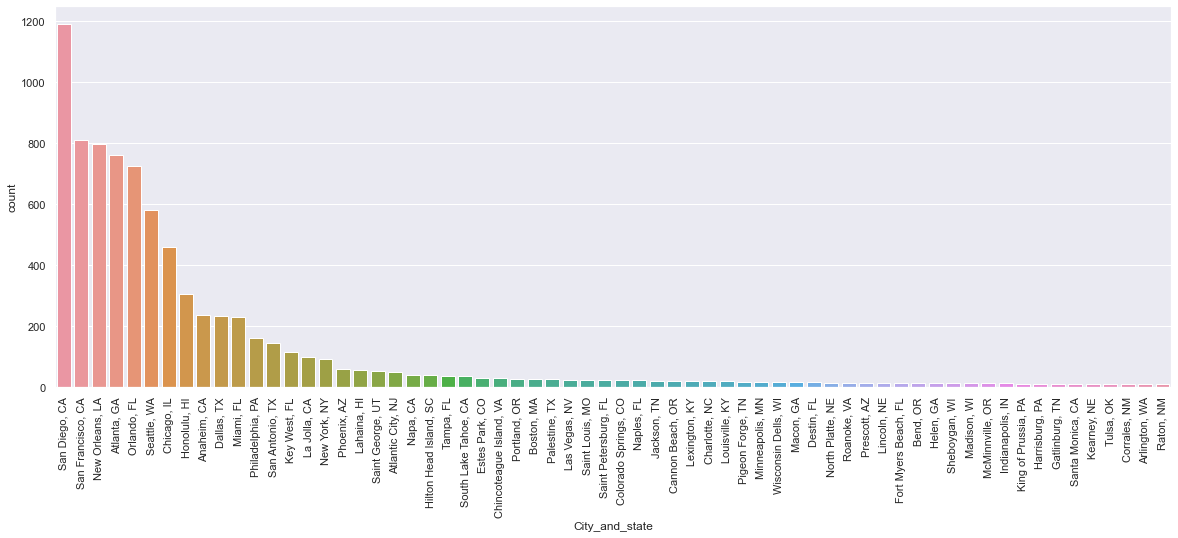

In [13]:
xaxis = cutoff.city_and_state.value_counts().index.tolist()
fig1 = plt.subplots(figsize = (20,7))
sns.countplot(x='City_and_state', data=cutoff, order = xaxis)
plt.xticks(rotation = 90)
plt.show()

In [34]:
### NLP PROCESSING

In [47]:
punc = ['.', ',', '"', "'", '?', '!', ':', ';', '(', ')', '[', ']', '{', '}',"%"]
ignore = set(stopwords.words('english'))
ignore.update(punc)

In [14]:
from utils import preprocess_text
cutoff["reviews_text_tokens"] = cutoff["reviews_text"].apply(lambda x: preprocess_text(x, min_word_length=4))
cutoff.head()

,id,address,city,country,latitude,longitude,name,postalCode,province,reviews_rating,reviews_text,reviews_title,sourceURLs,City_and_state,reviews_text_tokens
5,AVweLARAByjofQCxv5vX,167 W Main St,Lexington,US,38.047014,-84.497742,21c Museum Hotel Lexington,40507,KY,4,"This is such a fun, lovely hotel. The attentio...",Loved staying here,https://www.tripadvisor.com/Hotel_Review-g3958...,"Lexington, KY","[lovely, hotel, attention, detail, impressive,..."
6,AVweLARAByjofQCxv5vX,167 W Main St,Lexington,US,38.047014,-84.497742,21c Museum Hotel Lexington,40507,KY,1,We recently stayed at this hotel on a trip to ...,Does not live up to its reputation,https://www.tripadvisor.com/Hotel_Review-g3958...,"Lexington, KY","[recently, stay, hotel, trip, lexington, frien..."
8,AVz6h4Sb3D1zeR_xDHsu,2240 Buena Vista Rd,Lexington,US,38.042100,-84.427100,Microtel Inn Suites By Wyndham Lexington,40505,KY,5,MoreMore,Location Location Location,https://www.yellowbook.com/profile/microtel-in...,"Lexington, KY",[moremore]
10,AVwcuo0eIN2L1WUfoPEk,1953 Nicholasville Rd,Lexington,US,38.012430,-84.516350,Hampton Inn Lexington Medical Center,40503,KY,5,This is a new Hampton Inn and is well decorate...,Beautiful hotel,https://www.yellowpages.com/lexington-ky/mip/h...,"Lexington, KY","[hampton, decorate, color, scheme, give, feel,..."
13,AWV8VsCtRxPSIh2RyTvS,610 Poydras St,New Orleans,US,29.949125,-90.069748,The Whitney Hotel,70130,LA,3,The water is very hot and there's no cold wate...,"Very hot water, bad food",https://www.tripadvisor.com/Hotel_Review-g6086...,"New Orleans, LA","[water, cold, water, awful, food, good, staff,..."


In [51]:
import string
string.punctuation
punc = ['.', ',', '"', "'", '?', '!', ':', ';', '(', ')', '[', ']', '{', '}',"%"]
# punc = string.punctuation
stop_words = text.ENGLISH_STOP_WORDS.union(punc)
stemmer = SnowballStemmer('english')
tokenizer = RegexpTokenizer(r'[a-zA-Z\']+')

def tokenize(text):
    return [stemmer.stem(word) for word in tokenizer.tokenize(text.lower())]

desc = cutoff["reviews_text"].values
vectorizer = TfidfVectorizer(stop_words = stop_words, tokenizer = tokenize, max_features = 2000)
X = vectorizer.fit_transform(desc)

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\feature_extraction\text.py:383: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['abov', 'afterward', 'alon', 'alreadi', 'alway', 'ani', 'anoth', 'anyon', 'anyth', 'anywher', 'becam', 'becaus', 'becom', 'befor', 'besid', 'cri', 'describ', 'dure', 'els', 'elsewher', 'empti', 'everi', 'everyon', 'everyth', 'everywher', 'fifti', 'forti', 'henc', 'hereaft', 'herebi', 'howev', 'hundr', 'inde', 'mani', 'meanwhil', 'moreov', 'nobodi', 'noon', 'noth', 'nowher', 'onc', 'onli', 'otherwis', 'ourselv', 'perhap', 'pleas', 'sever', 'sinc', 'sincer', 'sixti', 'someon', 'someth', 'sometim', 'somewher', 'themselv', 'thenc', 'thereaft', 'therebi', 'therefor', 'togeth', 'twelv', 'twenti', 'veri', 'whatev', 'whenc', 'whenev', 'wherea', 'whereaft', 'wherebi', 'wherev', 'whi', 'yourselv'] not in stop_words.
  warnings.warn('Your stop_words may be inconsistent with '


AttributeError: 'list' object has no attribute 'lower'

In [46]:
word_features = vectorizer.get_feature_names()
len(word_features)

2000

In [47]:
print(word_features)

["'s", 'aaa', 'abl', 'abov', 'abri', 'absolut', 'ac', 'accept', 'access', 'accommod', 'accomod', 'accomplish', 'accord', 'account', 'acknowledg', 'act', 'action', 'activ', 'actual', 'ad', 'add', 'addit', 'address', 'adequ', 'adjac', 'adjoin', 'adjust', 'admit', 'ador', 'adult', 'advanc', 'advantag', 'adventur', 'advertis', 'advic', 'advis', 'advisor', 'affect', 'afford', 'afternoon', 'age', 'agent', 'ago', 'agre', 'ahead', 'aim', 'air', 'airlin', 'airport', 'alarm', 'alcohol', 'alex', 'allegro', 'allow', 'aloft', 'aloha', 'alon', 'alot', 'alreadi', 'altern', 'alway', 'alyssa', 'amaz', 'amber', 'ambianc', 'ambienc', 'amen', 'america', 'american', 'ami', 'ampl', 'anaheim', 'angel', 'ani', 'anim', 'annex', 'anniversari', 'annoy', 'annual', 'anoth', 'answer', 'anthoni', 'anticip', 'antonio', 'anyon', 'anyth', 'anytim', 'anywher', 'apart', 'apolog', 'appar', 'appear', 'appet', 'appl', 'appoint', 'appreci', 'approach', 'appropri', 'april', 'aquarium', 'architectur', 'area', "aren't", 'arrang

In [48]:
string.punctuation

'!"#$%&\'()*+,-./:;<=>?@[\\]^_`{|}~'